In [5]:
import sys 
sys.path.append('../')

import torch
import matplotlib.pyplot as plt 
from einops import repeat

import numpy as np
from src.dd_gmg import DD_GMG1D
from src.green_net import GreenNet1D
from src.model import MLP
from src.utils import rl2_error, matrl2_error
from src.dataset import load_dataset_1d
torch.set_printoptions(linewidth=120)

In [2]:
def Poisson(pts):
    x = (pts[...,0]+1)/2
    y = (pts[...,1]+1)/2
    return (x+y - (x-y).abs())/2 - x*y

In [3]:
def DoubleHoles(pts):
    x = pts[...,0]
    y = pts[...,1]
    r1 = ((x-0.1)**2 + (y-0.1)**2)**0.5
    r2 = ((x+0.1)**2 + (y+0.1)**2)**0.5
    return torch.nan_to_num(torch.log(r1), neginf=-8) - torch.nan_to_num(torch.log(r2), neginf=-8)

In [4]:
def Expdecay(pts):
    x = pts[...,0]
    y = pts[...,1]
    r1 = ((x-0.5)**2 + (y-0.5)**2)**0.5
    r2 = ((x+0.5)**2 + (y+0.5)**2)**0.5
    return torch.exp(-r1/0.05) + torch.exp(-r2/0.05)

In [5]:
n = 12
device = torch.device('cpu')
model = GreenNet1D(n=12, kernel=DoubleHoles, device=device, sub_num=5)
F = torch.squeeze(1 - model.grid.x_h**2)

In [6]:
model.eval_K()
K_full = model.K_hh.cpu().reshape(2**n+1, 2**n+1)

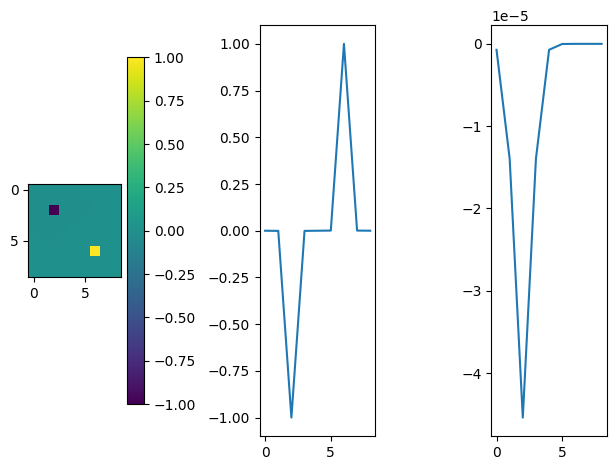

In [7]:
plt.subplot(131)
plt.imshow(K_full.cpu().reshape(2**n+1, 2**n+1))
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(132)
plt.plot(K_full.diag())
plt.subplot(133)
plt.plot(K_full[0])
plt.tight_layout()

In [8]:
U_full = model.full_kint(F)
print(U_full.shape)

torch.Size([9, 64])


Text(0.5, 1.0, 'output function U')

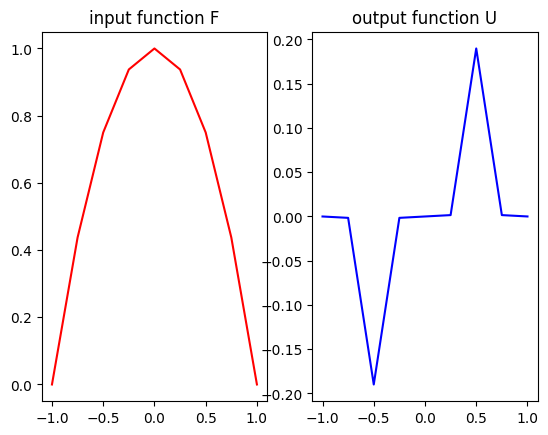

In [9]:
plt.subplot(121)
plt.plot(model.grid.x_h.cpu(), F[:,0].cpu(), '-r')
plt.title('input function F')
plt.subplot(122)
plt.plot(model.grid.x_h.cpu(), U_full[:,0].cpu(), '-b')
plt.title('output function U')

# Digonal Dominant Multi-Grid

influence of level of coarse: `k`

In [10]:
m = 1
for k in [1, 3, 5, 7]:
    dd_gmg = DD_GMG1D(n,m,k,Expdecay,device)
    dd_gmg.restrict_ml_f(F)
    dd_gmg.eval_ml_K()
    U_dd = dd_gmg.ml_kint(corr_odd=True)
    print('w   codd k {:d} - m {:d} - rl2 {:.4e}'.format(k, m, rl2_error(U_dd.T, U_full.T)))
    U_dd = dd_gmg.ml_kint(corr_odd=False)
    print('w/o codd k {:d} - m {:d} - rl2 {:.4e}'.format(k, m, rl2_error(U_dd.T, U_full.T)))

# coarest pts :  25
# correction :  26
ratio 51/81 = 62.96% 

w   codd k 1 - m 1 - rl2 3.4537e-03
w/o codd k 1 - m 1 - rl2 6.9549e-01
finest grid : 9
coarest grid : 2
too coarse warning
# coarest pts :  4
# correction :  43
ratio 47/81 = 58.02% 



RuntimeError: Calculated padded input size per channel: (1). Kernel size: (3). Kernel size can't be greater than actual input size

influence of correction range : `c`

In [ ]:
k = 3

for m in [0, 1, 3, 7, 15, 31, 65, 129]:
    dd_gmg = DD_GMG1D(n,m,k,Expdecay,device)
    dd_gmg.restrict_ml_f(F)
    dd_gmg.eval_ml_K()

    U_dd = dd_gmg.ml_kint(corr_odd=True)
    print('w   codd k {:d} - m {:d} - rl2 {:.4e}'.format(k, m, rl2_error(U_dd.T, U_full.T)))

    U_dd = dd_gmg.ml_kint(corr_odd=False)
    print('w/o codd k {:d} - m {:d} - rl2 {:.4e}'.format(k, m, rl2_error(U_dd.T, U_full.T)))

# coarest pts :  4225
# correction :  0
ratio 4225/263169 = 1.61% 

w   codd k 3 - m 0 - rl2 1.2917e-02
w/o codd k 3 - m 0 - rl2 1.2917e-02
# coarest pts :  4225
# correction :  3130
ratio 7355/263169 = 2.79% 

w   codd k 3 - m 1 - rl2 1.1315e-02
w/o codd k 3 - m 1 - rl2 1.2733e-02
# coarest pts :  4225
# correction :  8440
ratio 12665/263169 = 4.81% 

w   codd k 3 - m 3 - rl2 6.6439e-03
w/o codd k 3 - m 3 - rl2 1.5248e-02
# coarest pts :  4225
# correction :  18844
ratio 23069/263169 = 8.77% 

w   codd k 3 - m 7 - rl2 2.3343e-03
w/o codd k 3 - m 7 - rl2 1.7259e-02
# coarest pts :  4225
# correction :  38788
ratio 43013/263169 = 16.34% 

w   codd k 3 - m 15 - rl2 4.5969e-04
w/o codd k 3 - m 15 - rl2 1.7588e-02
# coarest pts :  4225
# correction :  75220
ratio 79445/263169 = 30.19% 

w   codd k 3 - m 31 - rl2 5.9137e-05
w/o codd k 3 - m 31 - rl2 1.7609e-02
# coarest pts :  4225
# correction :  137340
ratio 141565/263169 = 53.79% 

w   codd k 3 - m 65 - rl2 1.5364e-06
w/o codd k 3 - m 65

In [ ]:
# from tqdm import trange
# import numpy as np
# from src.ops import interp1d_cols, interp1d_rows

In [ ]:
# k = 5
# m = 6
# dd_gmg = DD_GMG1D(n,m,k,Logarithm,device)
# dd_gmg.restrict_ml_f(F)
# dd_gmg.eval_ml_K()
# U_dd = dd_gmg.ml_kint()
# print(rl2_error(U_dd.T, U_full.T).numpy())

In [ ]:
# grid_H = dd_gmg.ml_grids[-1]
# K_HH = dd_gmg.K_HH

In [ ]:
# grid_h = dd_gmg.ml_grids[0]
# nh = grid_h.nh
# grid_h.init_grid_hh()
# K_hh = Logarithm(grid_h.x_hh).reshape(nh, nh)
# coords_ij = dd_gmg.ml_grids[0].coords_ij
# mask_ij = dd_gmg.ml_grids[0].mask_ij
# K_ij = K_hh[coords_ij[...,0], coords_ij[...,1]] * mask_ij

In [ ]:
# coords_IJ = dd_gmg.ml_grids[-1].coords_ij
# mask_IJ = dd_gmg.ml_grids[-1].mask_ij
# K_IJ = K_HH[coords_IJ[...,0], coords_IJ[...,1]] * mask_IJ
# l=1
# nh = dd_gmg.ml_grids[-1-l].nh
# hh = dd_gmg.ml_grids[-1-l].hh
            
# # local evaluation and assemblation
# K_local_even, K_local_odd = dd_gmg.K_locals[l-1]
# K_ij_ = dd_gmg.local_assemble_K(K_IJ, K_local_even, K_local_odd)
# K_2Ij = K_ij_[::2]
                
# # local kernel interpolation
# K_local_even_, K_local_odd_ = dd_gmg.local_interp_K(K_IJ, K_2Ij)

# _, coords_even, mask_even = dd_gmg.pts_local[l-1][0]
# _, coords_odd, mask_odd = dd_gmg.pts_local[l-1][1]

K_band correctness

In [ ]:
# K_hh

In [ ]:
# K_2Ij

K_even Correctness

In [ ]:
# K_hh[::2][:,1::2]

In [ ]:
# K_local_even

K_even Interp Correctness

In [ ]:
# interp1d_cols(K_HH[None,None])[0,0][:,1::2]

In [ ]:
# K_local_even_

K_odd Correctness

In [ ]:
# K_hh[1::2]

In [ ]:
# K_local_odd

K_odd Interp

In [ ]:
# (K_hh[::2][:-1] + K_hh[::2][1:])/2

In [ ]:
# K_local_odd_